# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [234]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [235]:
# Load the Excel file into a pandas DataFrame


df_21Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=0 , skipfooter=2)
df_22Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=1 , skipfooter=2)
df_23Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)
df_24Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=3 , skipfooter=2)
df_30Oct = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=4 , skipfooter=2)
df_05Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=5 , skipfooter=2)
df_07Nov = pd.read_excel('./ST7 - AirFrance/DataSeating 2024.xlsx', sheet_name=6 , skipfooter=2)


In [236]:
# Display the DataFrame
df = df_30Oct
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,2.0,2.0,NaN,00:00:00
1,2,1.0,NaN,NaN,00:00:00
2,3,NaN,1.0,1.0,01:00:00
3,4,4.0,NaN,NaN,00:00:00
4,5,1.0,NaN,NaN,01:55:00
...,...,...,...,...,...
74,75,NaN,1.0,NaN,00:00:00
75,76,NaN,1.0,NaN,00:00:00
76,77,1.0,NaN,NaN,01:55:00
77,78,NaN,1.0,NaN,00:00:00


In [271]:

Passagers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0
transit_times= set()
for group in df.itertuples():
    for j in range(2,5):
        if not pd.isna(group[j]):
            for k in range(int(group[j])):
                Passagers[i] = {'gender': j-2, 'group':group[1], 'transit': float('inf') }
                if group[5].hour*60 + group[5].minute != 0:
                    Passagers[i]['transit'] = group[5].hour*60 + group[5].minute
                    transit_times.add(group[5].hour*60 + group[5].minute)
                if j == 2: number_f+=1
                elif j==3: number_m+=1
                else: number_d+=1

                i+=1    
Passagers

{1: {'gender': 0, 'group': 1, 'transit': inf},
 2: {'gender': 0, 'group': 1, 'transit': inf},
 3: {'gender': 1, 'group': 1, 'transit': inf},
 4: {'gender': 1, 'group': 1, 'transit': inf},
 5: {'gender': 0, 'group': 2, 'transit': inf},
 6: {'gender': 1, 'group': 3, 'transit': 60},
 7: {'gender': 2, 'group': 3, 'transit': 60},
 8: {'gender': 0, 'group': 4, 'transit': inf},
 9: {'gender': 0, 'group': 4, 'transit': inf},
 10: {'gender': 0, 'group': 4, 'transit': inf},
 11: {'gender': 0, 'group': 4, 'transit': inf},
 12: {'gender': 0, 'group': 5, 'transit': 115},
 13: {'gender': 0, 'group': 6, 'transit': inf},
 14: {'gender': 1, 'group': 6, 'transit': inf},
 15: {'gender': 1, 'group': 7, 'transit': inf},
 16: {'gender': 2, 'group': 7, 'transit': inf},
 17: {'gender': 1, 'group': 8, 'transit': inf},
 18: {'gender': 0, 'group': 9, 'transit': inf},
 19: {'gender': 0, 'group': 10, 'transit': inf},
 20: {'gender': 2, 'group': 10, 'transit': inf},
 21: {'gender': 0, 'group': 11, 'transit': 60},
 

: 

In [238]:
Groups = dict()


for i, passager in Passagers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]

Keys = list(Groups.keys()).copy()


for i in Keys:
        if len(Groups[i]) ==1: del(Groups[i])
Groups

{1: [1, 2, 3, 4],
 3: [6, 7],
 4: [8, 9, 10, 11],
 6: [13, 14],
 7: [15, 16],
 10: [19, 20],
 11: [21, 22, 23, 24, 25],
 15: [29, 30],
 17: [32, 33],
 18: [34, 35],
 19: [36, 37, 38],
 24: [43, 44],
 28: [48, 49],
 31: [52, 53],
 36: [58, 59, 60],
 37: [61, 62],
 46: [71, 72, 73],
 48: [75, 76],
 52: [80, 81, 82],
 59: [89, 90, 91],
 60: [92, 93],
 67: [100, 101],
 72: [106, 107],
 74: [109, 110]}

**Définition des paramètres utiles pour la suite**

In [239]:
weight_f = 70
weight_m = 85
weight_d = 92.5
if sum([4*number_d,number_f,number_m]) <= 174 :
    number_of_rows = 29 #modèle d'avion A320
else :
    number_of_rows = 35 #modèle d'avion A321

number_of_columns = 7 # ajout de la colonne qui correspond à l'allée


## Model

Defining the relevant variables of the problem

In [240]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passagers)+1)}

Les variables entières $i_{min}[g]$ et $i_{max}[g]$ (resp. $j_{min}[g]$ et $j_{max}[g]$) correspondent à la valeur de $i$ (resp. la valeur de $j$) la plus petite et la plus grande dans le groupe $g$.

In [241]:
# Variables X_{min}, X_{max}, Y_{min} et Y_{max}
i_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_min({g})') 
            for g in Groups.keys()}

i_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_rows , name=f'i_max({g})') 
            for g in Groups.keys()}

j_min = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns , name=f'j_min({g})') 
            for g in Groups.keys()}

j_max = {g : m.addVar(vtype = GRB.INTEGER, lb = 1 , ub = number_of_columns  , name=f'j_max({g})') 
            for g in Groups.keys()}

### Les contraintes 

- Contraintes liées à la définition des variables $i_min[g]$, $i_max[g]$, $j_min[g]$, $j_max[g]$

In [242]:


i_min_Passagers_Group = {(g,p) : m.addConstr(i_min[g] <= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

i_max_Passagers_Group = {(g,p) : m.addConstr(i_max[g] >= quicksum([i*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'i_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_min_Passagers_Group = {(g,p) : m.addConstr(j_min[g] <= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_min_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }

j_max_Passagers_Group = {(g,p) : m.addConstr(j_max[g] >= quicksum([j*AssignmenVarDict[(i,j,p)] 
                                                  for i in range(1, number_of_rows + 1) 
                                                  for j in range(1, number_of_columns + 1)]), 
                                                  name = f'j_max_Passager_{p}Group_{g}') 
                                                  for g in Groups.keys()
                                                  for p in Groups[g]
                                                  }



- Every person has one seat

In [243]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passagers)+1) }

- Every seat is allocated to a single person

In [244]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passagers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Personne n'est assis au niveau de l'allée

In [245]:
AISLECONSTDIC = { i : m.addConstr(quicksum([AssignmenVarDict[(i,4,k)]
                                                     for k in range(1, len(Passagers)+1)])
                                                     == 0)
                                                     for i in range(1, number_of_rows + 1)   
}

- Barycenter constraint

In [246]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])

i_f = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])

i_d = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])

j_f = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])

j_d = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [247]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 5)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [248]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 6] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passagers) + 1)
                                               if Passagers[k]['gender'] == 2}

for k in range(1, len(Passagers) + 1):
    if Passagers[k]['gender'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 6]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Objectif Time

- Transit time

In [249]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passagers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passagers)+1)
                      if Passagers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [250]:
m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 0.96                                                    



- Transit time visualization

In [251]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

In [252]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passagers[k]['transit']]
                elif j > 4 :
                    data2[i-1][j-5] = k
                    if Passagers[k]['transit']!=float('inf'): colors2[i-1][j-5] = color_transit[Passagers[k]['transit']]

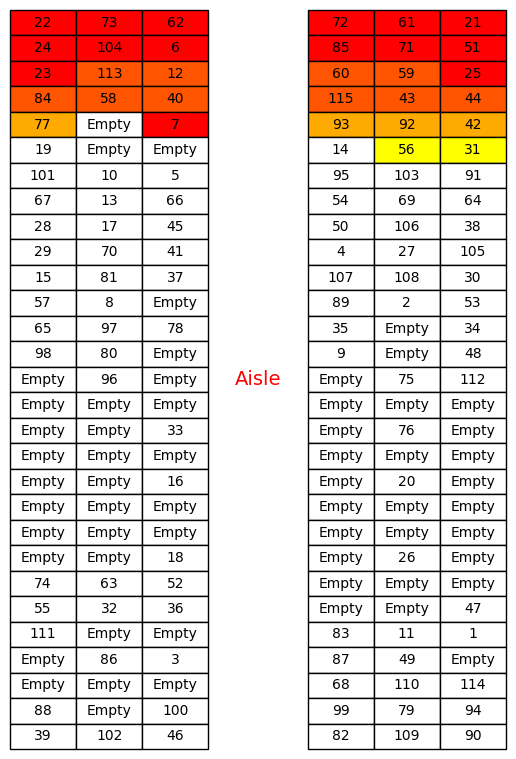

In [253]:

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

In [254]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['gender']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                elif j>4:
                    data2[i-1][j-5] = k
                    if Passagers[k]['gender']==2:
                        colors2[i-1][j-5] = '#800080'
                        colors2[i-1][j-6] = '#800080'
                        colors2[i][j-5] = '#800080'
                        colors2[i][j-6] = '#800080'




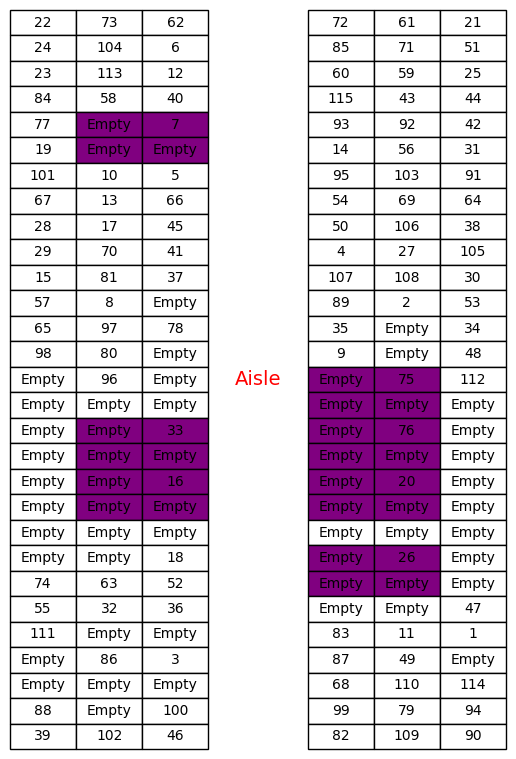

In [255]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Objectif Grouping

- 1st formulation

In [256]:
'''grouping = quicksum([AssignmenVarDict[(i_1, j_1, group[k_1])] * AssignmenVarDict[(i_2, j_2, group[k_2])] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2)) \
                     for group in Groups.values() \
                     for k_1 in range(len(group)) \
                     for k_2 in range(k_1 + 1, len(group)) \
                     for i_1 in range(1, number_of_rows + 1) \
                     for j_1 in range(1, number_of_columns + 1) \
                     for i_2 in range(1, number_of_rows + 1) \
                     for j_2 in range(1, number_of_columns + 1)])

m.setObjective(grouping, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()'''

'grouping = quicksum([AssignmenVarDict[(i_1, j_1, group[k_1])] * AssignmenVarDict[(i_2, j_2, group[k_2])] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2))                      for group in Groups.values()                      for k_1 in range(len(group))                      for k_2 in range(k_1 + 1, len(group))                      for i_1 in range(1, number_of_rows + 1)                      for j_1 in range(1, number_of_columns + 1)                      for i_2 in range(1, number_of_rows + 1)                      for j_2 in range(1, number_of_columns + 1)])\n\nm.setObjective(grouping, GRB.MINIMIZE)\n\nm.params.outputflag = 0 \n\nm.update()'

- 2nd formulation

In [257]:
'''grouping = quicksum([AssignmenVarDict[(i_1, j_1, k_1)] * AssignmenVarDict[(i_2, j_2, k_2)] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2)) \
                     for i_1 in range(1, number_of_rows + 1) \
                     for j_1 in range(1, number_of_columns + 1) \
                     for i_2 in range(1, number_of_rows + 1) \
                     for j_2 in range(1, number_of_columns + 1)\
                        for k_1 in Passagers.keys()
                        for k_2 in Passagers.keys()
                        if Passagers[k_1]['group'] == Passagers[k_2]['group'] and k_1 != k_2])

m.setObjective(grouping, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()'''

"grouping = quicksum([AssignmenVarDict[(i_1, j_1, k_1)] * AssignmenVarDict[(i_2, j_2, k_2)] * (0.7 * abs(i_1 - i_2) + 0.3 * abs(j_1 - j_2))                      for i_1 in range(1, number_of_rows + 1)                      for j_1 in range(1, number_of_columns + 1)                      for i_2 in range(1, number_of_rows + 1)                      for j_2 in range(1, number_of_columns + 1)                        for k_1 in Passagers.keys()\n                        for k_2 in Passagers.keys()\n                        if Passagers[k_1]['group'] == Passagers[k_2]['group'] and k_1 != k_2])\n\nm.setObjective(grouping, GRB.MINIMIZE)\n\nm.params.outputflag = 0 \n\nm.update()"

**Nouvelle Fonction Objective**

In [258]:

AssignmenVarGrpDict = { (g , i, j , Groups[g][k], Groups[g][l]) : m.addVar(vtype = GRB.BINARY, name=f'Y_{i}_{j}_{Groups[g][k]}_{Groups[g][l]}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns)
                    for g in Groups.keys()
                    for k in range(len(Groups[g]))
                    for l in range(k+1,len(Groups[g]))
                    }


In [259]:

GroupingConstDict1 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j,Groups[g][k])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     }

GroupingConstDict2 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] <= AssignmenVarDict[(i,j+1,Groups[g][l])])
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     }

GroupingConstDict3 = { g : m.addConstr( AssignmenVarGrpDict[(g,i,j,Groups[g][k],Groups[g][l])] >= 
                                       AssignmenVarDict[(i,j+1,Groups[g][l])] + AssignmenVarDict[(i,j,Groups[g][k])] -1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     }

obj_grouping = quicksum([AssignmenVarGrpDict[(g, i , j, Groups[g][k], Groups[g][l])]
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns)
                                                     for g in Groups.keys()
                                                     for k in range(len(Groups[g]))
                                                     for l in range(k+1,len(Groups[g]))
                                                     
                         ])

m.setObjective(obj_grouping, GRB.MAXIMIZE)






**Nouvelle fonction objective**

In [260]:
'''
obj_grouping = quicksum([10*(i_max[g] - i_min[g]) + (j_max[g] - j_min[g])
                        for g in Groups.keys()])
m.setObjective(obj_grouping, GRB.MINIMIZE)
'''

'\nobj_grouping = quicksum([10*(i_max[g] - i_min[g]) + (j_max[g] - j_min[g])\n                        for g in Groups.keys()])\nm.setObjective(obj_grouping, GRB.MINIMIZE)\n'

In [261]:


m.params.outputflag = 0

m.update()


In [262]:
num_vars = m.NumVars
num_vars

32663

## Optimisation


In [263]:
# Set iteration limit
m.setParam(GRB.Param.TimeLimit, 100)  # Change 1000 to the desired iteration limit

m.optimize()
iteration = 1

if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()




                                                   z* = 28.0                                                    



In [264]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1) }

In [265]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passagers[k]['group']]
                else:
                    data2[i-1][j-5] = k
                    if Passagers[k]['group'] in color_group: colors2[i-1][j-5] = color_group[Passagers[k]['group']]

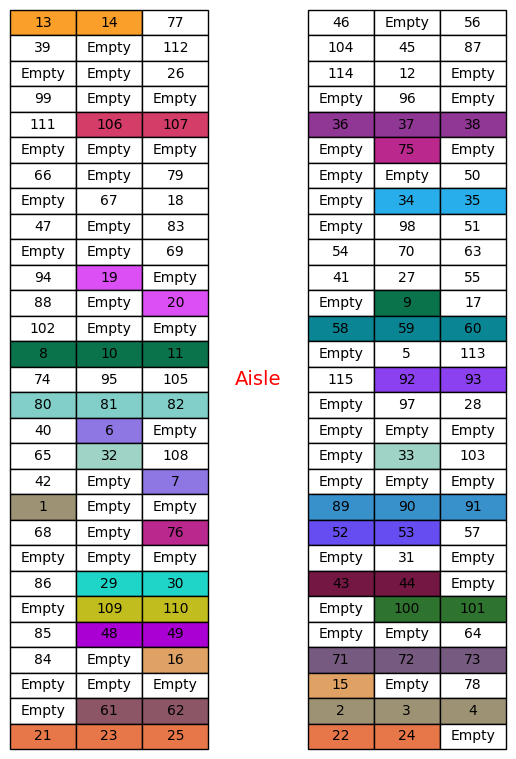

In [266]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

In [267]:
# Définition des constantes pour les niveaux de satisfaction
SATISFIED = 1.0
MEDIUM_SATISFIED = 0.5
NOT_SATISFIED = 0.0

# Initialisation des variables pour les scores de satisfaction
satisfaction_scores = []

# Vérification pour chaque passager s'il est assis à côté d'un membre de son groupe
for group, passengers in Groups.items():
    print(passengers)
    for pass_id in passengers:
        # Récupérer la position du passager dans l'avion
        seat_positions = [(i, j) for i in range(1, number_of_rows+1)
                          for j in range(1, number_of_columns+1)
                          if AssignmenVarDict.get((i, j, pass_id), 0).x == 1]
        
        if seat_positions:  # Vérifie si la liste n'est pas vide
            seat_position = seat_positions[0]  # Prend le premier élément
            print(f"Le passager {pass_id} est assis à la position {seat_position}")
        else:
            print(f"Aucun siège trouvé pour le passager {pass_id}. Vérifiez l'indexation et les données.")

        i, j = seat_position
        
    
        
        # # Vérifier s'il y a des membres du groupe à côté
        seat_left = (i, j-1) if j-1 > 0 else None
        seat_right = (i, j+1) if j+1 <= number_of_columns else None
        
        # # Vérifier pour chaque siège s'il est occupé par un membre du groupe
        # left_satisfaction = (AssignmenVarDict[(seat_left[0], seat_left[1], pass_id)].x == 1) if seat_left else NOT_SATISFIED
        # right_satisfaction = (AssignmenVarDict[(seat_right[0], seat_right[1], pass_id)].x == 1) if seat_right else NOT_SATISFIED

        # Vérifiez s'il y a des membres du groupe à côté dans la même rangée, à gauche ou à droite
        neighbors = [seat_left, seat_right]  # Positions des sièges voisins directement à gauche et à droite
        
        for neighbor in neighbors:
            if neighbor is not None:  # Ajoutez cette vérification pour éviter l'erreur
                ni, nj = neighbor
                if nj == 4 or j == 4:  # S'ils sont séparés par l'allée, attribuez MEDIUM_SATISFIED
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if other_pass_id != pass_id):
                        satisfaction = MEDIUM_SATISFIED
                elif 1 <= nj <= number_of_columns and nj != 4:  # S'ils sont directement à côté sans allée entre eux
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if other_pass_id != pass_id):
                        satisfaction = SATISFIED
                else:
                    satisfaction = NOT_SATISFIED
            else:
                # Si neighbor est None...
                continue  # Passe au prochain voisin sans faire d'autres actions

        print(satisfaction)

        
        # Évaluation de la satisfaction du passager

        # if left_satisfaction or right_satisfaction:
        #     satisfaction = SATISFIED
        # elif seat_left and any(AssignmenVarDict[(seat_left[0], seat_left[1], other_pass_id)].x == 1 for other_pass_id in passengers):
        #     satisfaction = MEDIUM_SATISFIED
        # elif seat_right and any(AssignmenVarDict[(seat_right[0], seat_right[1], other_pass_id)].x == 1 for other_pass_id in passengers):
        #     satisfaction = MEDIUM_SATISFIED
        # else:
        #     satisfaction = NOT_SATISFIED

        # print(satisfaction)
        
        # Ajouter le score de satisfaction à la liste
        satisfaction_scores.append(satisfaction)

for pass_id in range(1, len(Passagers) + 1):
    if all(pass_id not in passengers for _, passengers in Groups.items()):
        # Ce passager est seul
        # print(f"Le passager {pass_id} est seul et est automatiquement SATISFIED.")
        satisfaction_scores.append(SATISFIED)

# Calcul du score de groupement moyen (pourcentage de satisfaction)
grouping_score = sum(satisfaction_scores) / len(satisfaction_scores)

# Retourner le score de groupement en pourcentage
grouping_score_percentage = grouping_score * 100
grouping_score_percentage

[1, 2, 3, 4]
Le passager 1 est assis à la position (20, 1)
1.0
Le passager 2 est assis à la position (28, 5)
1.0
Le passager 3 est assis à la position (28, 6)
1.0
Le passager 4 est assis à la position (28, 7)
1.0
[6, 7]
Le passager 6 est assis à la position (17, 2)
1.0
Le passager 7 est assis à la position (19, 3)
1.0
[8, 9, 10, 11]
Le passager 8 est assis à la position (14, 1)
1.0
Le passager 9 est assis à la position (12, 6)
1.0
Le passager 10 est assis à la position (14, 2)
1.0
Le passager 11 est assis à la position (14, 3)
1.0
[13, 14]
Le passager 13 est assis à la position (1, 1)
1.0
Le passager 14 est assis à la position (1, 2)
1.0
[15, 16]
Le passager 15 est assis à la position (27, 5)
1.0
Le passager 16 est assis à la position (26, 3)
1.0
[19, 20]
Le passager 19 est assis à la position (11, 2)
1.0
Le passager 20 est assis à la position (12, 3)
1.0
[21, 22, 23, 24, 25]
Le passager 21 est assis à la position (29, 1)
1.0
Le passager 22 est assis à la position (29, 5)
1.0
Le passag

100.0

In [268]:
# Définition des constantes pour les niveaux de satisfaction
SATISFIED = 1.0
MEDIUM_SATISFIED = 0.5
NOT_SATISFIED = 0.0

# Initialisation des variables pour les scores de satisfaction
satisfaction_scores = []

for group, passengers in Groups.items():
    print(passengers)
    for pass_id in passengers:
        seat_positions = [(i, j) for i in range(1, number_of_rows+1)
                            for j in range(1, number_of_columns+1)
                            if AssignmenVarDict.get((i, j, pass_id), 0).x == 1]
        if seat_positions:  # Vérifie si la liste n'est pas vide
            seat_position = seat_positions[0]  # Prend le premier élément
            print(f"** Le passager {pass_id} est assis à la position {seat_position}")
        else:
            print(f"Aucun siège trouvé pour le passager {pass_id}. Vérifiez l'indexation et les données.")
            
        i, j = seat_position
        neighbors = [(i, j-1), (i, j+1)]
        satisfaction = 0
        for neighbor in neighbors:
            ni, nj = neighbor
            if 1 <= nj <= number_of_columns:
                if nj == 4 or j == 4:  # S'ils sont séparés par l'allée, attribuez MEDIUM_SATISFIED seulement si dans la même rangée
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if other_pass_id != pass_id):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, Medium")
                        satisfaction = max(satisfaction, MEDIUM_SATISFIED)
                elif nj != 4:
                    if any(AssignmenVarDict.get((ni, nj, other_pass_id), 0).x == 1 for other_pass_id in passengers if (other_pass_id != pass_id and ni == i)):
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, True")
                        satisfaction = max(satisfaction, SATISFIED)
                    else :
                        print(f"Pass {pass_id}, Seat {i, j}, Neighbor {neighbor}, False")
                        satisfaction = max(satisfaction, NOT_SATISFIED)
        satisfaction_scores.append(satisfaction)
        print(f"** Passager {pass_id} -- satisfaction {satisfaction}\n")

for pass_id in range(1, len(Passagers) + 1):
    if all(pass_id not in passengers for _, passengers in Groups.items()):
        # Ce passager est seul
        # print(f"Le passager {pass_id} est seul et est automatiquement SATISFIED.")
        satisfaction_scores.append(SATISFIED)

# Calcul du score de groupement moyen (pourcentage de satisfaction)
grouping_score = sum(satisfaction_scores) / len(satisfaction_scores)

# Retourner le score de groupement en pourcentage
grouping_score_percentage = grouping_score * 100
grouping_score_percentage


[1, 2, 3, 4]
** Le passager 1 est assis à la position (20, 1)
Pass 1, Seat (20, 1), Neighbor (20, 2), False
** Passager 1 -- satisfaction 0

** Le passager 2 est assis à la position (28, 5)
Pass 2, Seat (28, 5), Neighbor (28, 6), True
** Passager 2 -- satisfaction 1.0

** Le passager 3 est assis à la position (28, 6)
Pass 3, Seat (28, 6), Neighbor (28, 5), True
Pass 3, Seat (28, 6), Neighbor (28, 7), True
** Passager 3 -- satisfaction 1.0

** Le passager 4 est assis à la position (28, 7)
Pass 4, Seat (28, 7), Neighbor (28, 6), True
** Passager 4 -- satisfaction 1.0

[6, 7]
** Le passager 6 est assis à la position (17, 2)
Pass 6, Seat (17, 2), Neighbor (17, 1), False
Pass 6, Seat (17, 2), Neighbor (17, 3), False
** Passager 6 -- satisfaction 0

** Le passager 7 est assis à la position (19, 3)
Pass 7, Seat (19, 3), Neighbor (19, 2), False
** Passager 7 -- satisfaction 0

[8, 9, 10, 11]
** Le passager 8 est assis à la position (14, 1)
Pass 8, Seat (14, 1), Neighbor (14, 2), True
** Passag

89.56521739130436

In [269]:
for i in range(1, number_of_rows+1):
    for j in range(1, number_of_columns+1):
        if AssignmenVarDict[(i,j,61)].X ==1:
            print(i,j)

28 2


In [270]:
Passagers[61]

{'gender': 0, 'group': 37, 'transit': 60}